# *학습 관련 기술들*

## 4. 바른 학습을 위해

- 기계학습에서는 오버피팅이 문제가 되는 경우가 많으며, 이를 억제하는 기술이 중요
___

### 1) 오버피팅
- 오버피팅은 주로 다음 두 경우에 발생
> - 매개변수가 많고 표현력이 높은 모델
> - 훈련 데이터가 적은 경우

- 의도적으로 오버피팅을 발생시키기 위해 훈련 데이터를 300/60,000개 사용하고 7층 네트워크를 사용
- 각 층 뉴런은 100개, 활성화 함수는 ReLU 사용, 학습 방법은 Adam 시도

In [11]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from data.mnist import load_mnist
from data.multi_layer_net import MultiLayerNet
from data.optimizer import SGD
from data.optimizer import Adam
from data.optimizer import AdaGrad

- 원하는 데이터만 추출 (1~300번)

In [15]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

- 아래와 같이 기본 세팅 설정 (network구성, weight decay, 학습방법 설정, batch/epochs 구성 등)

In [16]:
# weight decay（가중치 감쇠） 설정 =======================
weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
#weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

- max_epochs까지 for문 수행

In [18]:
for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        if i % (iter_per_epoch*10) == 0:
            print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


epoch:0, train acc:0.09, test acc:0.1057
epoch:10, train acc:0.38333333333333336, test acc:0.2858
epoch:20, train acc:0.51, test acc:0.3732
epoch:30, train acc:0.7566666666666667, test acc:0.5631
epoch:40, train acc:0.84, test acc:0.6549
epoch:50, train acc:0.8766666666666667, test acc:0.6826
epoch:60, train acc:0.9033333333333333, test acc:0.7031
epoch:70, train acc:0.9433333333333334, test acc:0.7185
epoch:80, train acc:0.9666666666666667, test acc:0.7179
epoch:90, train acc:0.9866666666666667, test acc:0.7321
epoch:100, train acc:0.9966666666666667, test acc:0.7369
epoch:110, train acc:0.9966666666666667, test acc:0.7415
epoch:120, train acc:1.0, test acc:0.7432
epoch:130, train acc:1.0, test acc:0.7481
epoch:140, train acc:1.0, test acc:0.7495
epoch:150, train acc:1.0, test acc:0.7499
epoch:160, train acc:1.0, test acc:0.7546
epoch:170, train acc:1.0, test acc:0.7526
epoch:180, train acc:1.0, test acc:0.7514
epoch:190, train acc:1.0, test acc:0.753
epoch:200, train acc:1.0, test ac

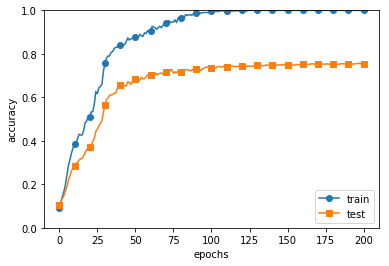

In [19]:
# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

- 위의 그래프에서 볼 수 있듯이 train 데이터에서의 정확도가 100에폭부터 거의 100%에 근사하는 반면, test데이터에서의 정확도간에 큰 오차 발생
- 위같은 사례를 오버피팅이라고 볼 수 있음
___

### 2) 가중치 감소

- 오버피팅 방지를 위해 **weight decay(가중치 감소)**가 가장 빈번하게 사용됨

- 오버피팅은 가중치 매개변수의 값이 커서 발생하는 경우가 많기 때문에 큰 가중치에 상응하는 패널티를 부과하여 오버피팅 억제를 시도 (panelty)

> ### Recap
> - 신경망 학습의 목적은 손실함수 값 최소화
- 따라서 가중치의 L2 norm(제곱 norm)을 손실함수에 더하며 가중치가 커지느 것을 억제 가능
- L2 norm에 따른 가중치 감소는 $\frac{1}{2}\lambda W^2$가 됨
- 여기서 $\lambda$는 하이퍼파라미터로 패널티 규모를 설정, 앞쪽의 $\frac{1}{2}$는 미분 결과인 $\lambda W$를 조정하는 역할의 상수
- 가중치 감소는 모든 가중치의 손실함수에 $\frac{1}{2}\lambda W^2$를 더하며, 기울기 계산 시 정규화 항을 미분한 $\lambda W$를 더함
___
- $W = (w_1, w_2, w_3, ... , w_n)$일 때
- L2 norm $= \sqrt{w_1^2 + w_2^2 + w_3^2 + ... + w_n^2}$ 이며,
- L1 norm $ = \lvert w_1^2 \rvert + \lvert w_2^2 \rvert + \lvert w_3^2 \rvert + ... +\lvert w_n^2 \rvert$ 로 표현 가능

- 위 실험에서 weight decay를 적용하여 $\lambda = 0.1$로 재실험하면 아래와 같은 결과 기대

In [23]:
# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

In [24]:
for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        if i % (iter_per_epoch*10) == 0:
            print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            print('finish')
            break


epoch:0, train acc:0.15333333333333332, test acc:0.1076
epoch:10, train acc:0.34, test acc:0.2143
epoch:20, train acc:0.5066666666666667, test acc:0.3568
epoch:30, train acc:0.5766666666666667, test acc:0.4238
epoch:40, train acc:0.6433333333333333, test acc:0.4916
epoch:50, train acc:0.6966666666666667, test acc:0.5448
epoch:60, train acc:0.8033333333333333, test acc:0.6111
epoch:70, train acc:0.8266666666666667, test acc:0.6421
epoch:80, train acc:0.85, test acc:0.6713
epoch:90, train acc:0.8566666666666667, test acc:0.6781
epoch:100, train acc:0.8733333333333333, test acc:0.6958
epoch:110, train acc:0.9033333333333333, test acc:0.7029
epoch:120, train acc:0.8933333333333333, test acc:0.7056
epoch:130, train acc:0.89, test acc:0.7117
epoch:140, train acc:0.9, test acc:0.7223
epoch:150, train acc:0.9133333333333333, test acc:0.7298
epoch:160, train acc:0.93, test acc:0.7317
epoch:170, train acc:0.9266666666666666, test acc:0.7234
epoch:180, train acc:0.9233333333333333, test acc:0.736

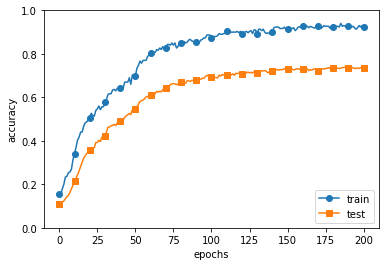

In [25]:
# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

- 주목할 점은 2가지 정도임
> 1) training과 test set 결과 간의 오차율이 줄어듬
>
> 2) 전체적인 정확도가 100%에 도달하지 못함

___